In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import polars as pl
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch_geometric as tg
from torch_geometric.utils.convert import from_networkx
import networkx as nx
from collections import deque

In [3]:
import local2global_embedding as emb
import local2global_embedding.embedding.gae as gae
import local2global_embedding.embedding.dgi as dgi
from local2global_embedding.network import TGraph
from local2global_embedding.run.utils import load_data
#import local2global as l2g

In [4]:
from datasets import DataLoader

ModuleNotFoundError: No module named 'dataloader'

# Autonomous systems dataset

An autonomous system (AS) is a large network or collection of networks that is managed by a single entity or organization, such as an Internet Service Provider (ISP), a university, or a corporation. AS use the [Border Gateway Protocol (BGP)](https://en.wikipedia.org/wiki/Border_Gateway_Protocol) to exchange routing information among each other. This allows them to determine the most efficient paths for data to travel across the internet.

The [SNAP autonomous systems AS-733](https://snap.stanford.edu/data/as-733.html) dataset contains 733 daily snapshots that span an interval of 785 days from November 8 1997 to January 2 2000. In each of these datasets, nodes represent autonomous systems and edges indicate whether communication has taken place. The resulting graph is undirected.

## Load and explore dataset

In [5]:
# To easily access the graphs for different days, in edge_index format
dl = DataLoader(dataset='AS-733')
graph = dl.get_graph('20000102')
graph

array([[    1,     1,     1, ..., 65002, 65051, 65105],
       [  701,  2914,  2828, ...,  6509,  1668, 10994]])

In [6]:
# Get stats: number of nodes, edges and average degree
n_nodes = []
n_edges = []
average_degrees = []

for d in dl.dates:
    graph = dl.get_graph(d)
    nodes, counts = np.unique(graph[0,:], return_counts=True)
    n_nodes.append(len(nodes))
    average_degrees.append(counts.mean())
    n_edges.append(np.sum(graph[0,:]<=graph[1,:]))

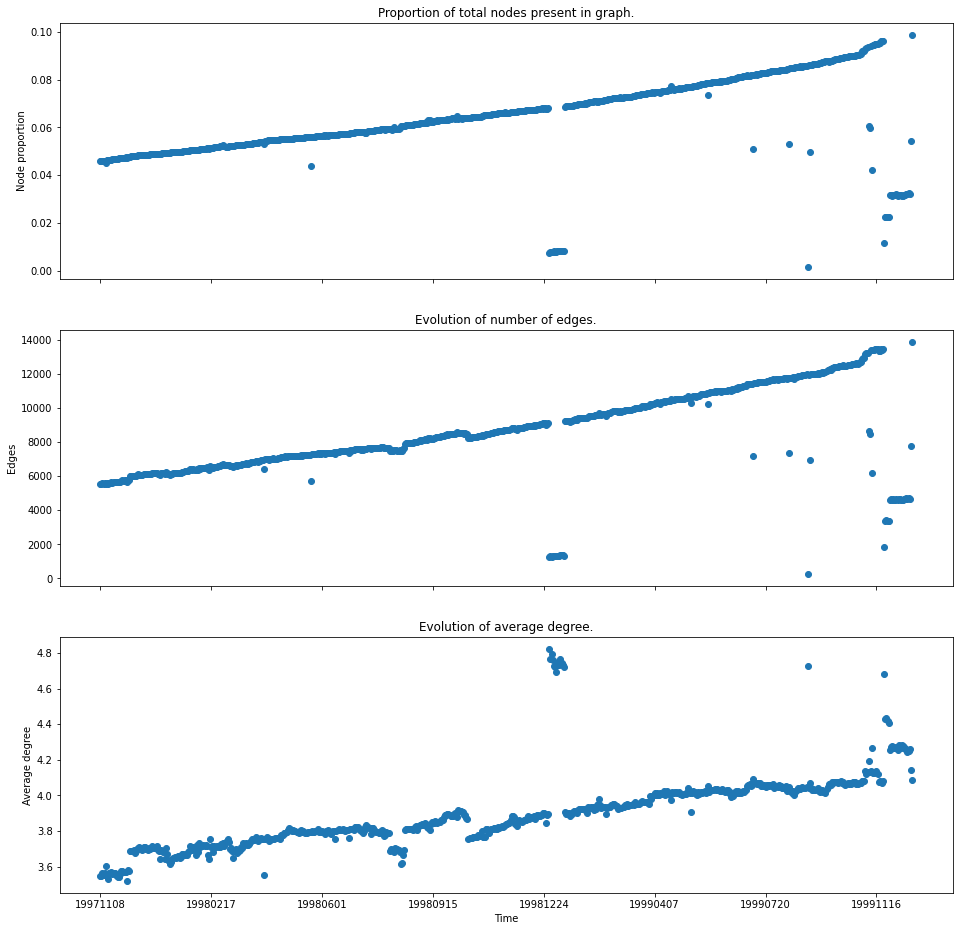

In [7]:
fig, ax = plt.subplots(3, 1, figsize=(16, 16), sharex=True)

xticks = np.arange(0, len(dl.dates), 100)
xlabels = [dl.dates[i] for i in xticks]

node_prop = [float(x)/dl.num_nodes for x in n_nodes]
ax[0].plot(node_prop, 'o')
ax[0].set_ylabel("Node proportion")
ax[0].set_title("Proportion of total nodes present in graph.")

ax[1].plot(n_edges, 'o')
ax[1].set_ylabel("Edges")
ax[1].set_title("Evolution of number of edges.")

ax[2].plot(average_degrees, 'o')
ax[2].set_xlabel("Time")
ax[2].set_xticks(xticks, labels=xlabels)
ax[2].set_ylabel("Average degree")
ax[2].set_title("Evolution of average degree.")

plt.show()

There appear to be some outliers from December 28, 1998 to January 11, 1999. Not sure if this has to do with the data collection.

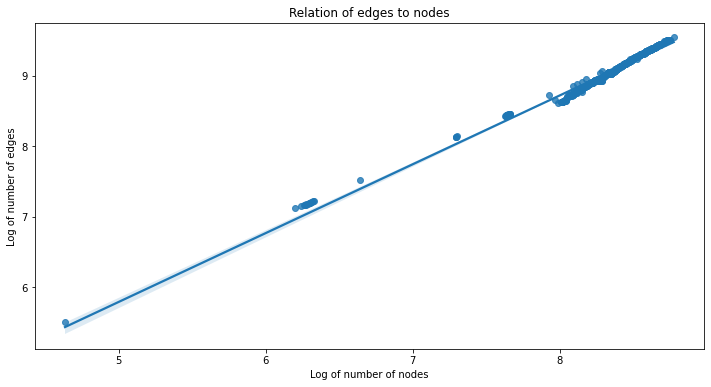

In [8]:
node_edges = pl.DataFrame({'nodes': [np.log(float(x)) for x in n_nodes], 
                           'edges': [np.log(float(x)) for x in n_edges]})
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.regplot(data=node_edges, x='nodes', y='edges')
ax.set_xlabel('Log of number of nodes')
ax.set_ylabel('Log of number of edges')
ax.set_title('Relation of edges to nodes')
plt.show()

Figure out in how many days each nodes features.

In [9]:
node_matrix = np.zeros((dl.num_nodes, len(dl.dates)))
for i,d in enumerate(dl.dates):
    graph = dl.get_graph(d)
    active_nodes = np.unique(graph[:,0])
    node_idx = [x-1 for x in active_nodes]
    node_matrix[node_idx, i] = 1

In [10]:
node_df = pl.from_numpy(node_matrix, schema=dl.dates)
node_hist = pl.DataFrame({'node': np.arange(1, dl.num_nodes+1),
                          'prevalence': np.sum(node_matrix, axis=1)})

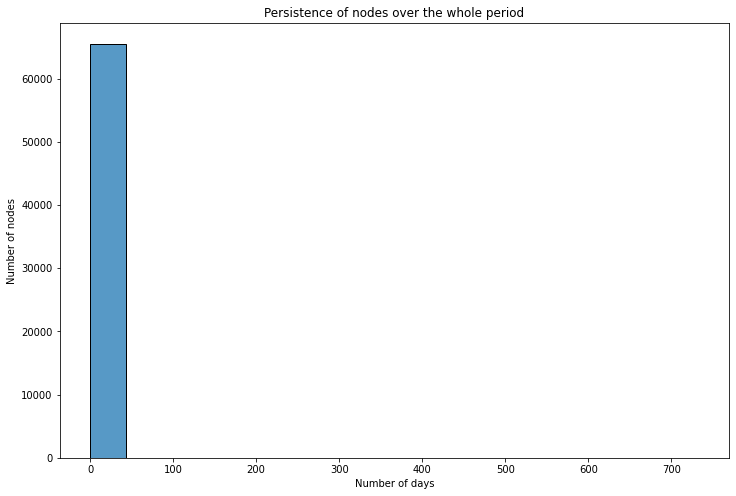

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))
sns.histplot(data=node_hist, x='prevalence')
ax.set_xlabel('Number of days')
ax.set_ylabel('Number of nodes')
ax.set_title('Persistence of nodes over the whole period')
plt.show()

Most nodes only feature on few days, while a minority of nodes persist throughout. Next, figure out how many nodes and edges get carried over from one day to the next.

In [12]:
graphs = dl.get_all_graphs()

In [13]:
list_set_nodes=[set(np.unique(g[0,:])) for g in graphs]
nodes_in_intersection=set.intersection(*[set(gr) for gr in list_set_nodes])
print(f'The number of nodes in the intersection of all graphs is:', len(nodes_in_intersection))

The number of nodes in the intersection of all graphs is: 45


Figure out the intersection of two consecutive graphs.